In [356]:
import pandas as pd
import os
import datetime
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Lambda
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import normalize
from keras import backend as K
from keras.losses import mse, binary_crossentropy
import matplotlib.pyplot as plt


In [52]:
os.listdir()

['Datasets.zip',
 '.DS_Store',
 'Inmate_Admissions Data Dictionary.xlsx',
 'Datasets',
 'ACS Artificial Intelligence Starter Guide.pdf',
 '16-0026_DATA61_REPORT_TomorrowsDigiallyEnabledWorkforce_WEB_160128.pdf',
 'Offence Charge Code Lookup.xlsx',
 'Inmate_Admissions.csv',
 'DirectedIdeation_20190708123418.ipynb',
 'ACS_Data-Sharing-Frameworks_FINAL_FA_SINGLE_LR.pdf',
 'directed',
 'Inmate_Admissions_sample.csv',
 'AFR-jobs-of-the-future-5JUN2018.pdf',
 'RecurrentVariationalAutoencoder.ipynb',
 '.ipynb_checkpoints',
 'ACS Data Sharing Taskforce - Directed Ideation Report - 26th March 2019_v1.1.pdf',
 'ACS Directed Ideation - Information Evening 1st July 2019_v1_3.pptx']

In [53]:
data = pd.read_csv('Inmate_Admissions.csv')

In [54]:
data.shape

(301747, 7)

In [55]:
data.dtypes

INMATEID               int64
ADMITTED_DT           object
DISCHARGED_DT         object
RACE                  object
GENDER                object
INMATE_STATUS_CODE    object
TOP_CHARGE            object
dtype: object

In [56]:
data = data.fillna(0)

In [57]:
data.ADMITTED_DT = data.ADMITTED_DT.astype('datetime64[ns]')
data.DISCHARGED_DT = data.DISCHARGED_DT.astype('datetime64[ns]')

In [65]:
def lookup_vals(myval, mydict):
    try:
        return mydict[myval]
    except KeyError:
        return None
    
    
def create_sparse_dict(df):
    labels = df.value_counts().sort_values()
    lookup_dict = {}
    c = 1 # starting from 1 because we will 0-pad
    for i, v in labels.items():
        lookup_dict[i] = c
        c += 1
    df = pd.DataFrame(df.apply(lookup_vals, args=(lookup_dict,)))
    return df, lookup_dict


def date_to_int(dt):
    return (dt - datetime.datetime(1970,1,1)).total_seconds()

In [59]:
data.RACE, race_dict = create_sparse_dict(data.RACE)

In [60]:
data.GENDER, gender_dict = create_sparse_dict(data.GENDER)

In [61]:
data.INMATE_STATUS_CODE, status_dict = create_sparse_dict(data.INMATE_STATUS_CODE)

In [62]:
data.TOP_CHARGE, charge_dict = create_sparse_dict(data.TOP_CHARGE)

In [70]:
data.ADMITTED_DT = data.ADMITTED_DT.apply(date_to_int)

In [71]:
data.DISCHARGED_DT = data.DISCHARGED_DT.apply(date_to_int)

In [73]:
data.dtypes

INMATEID                int64
ADMITTED_DT           float64
DISCHARGED_DT         float64
RACE                    int64
GENDER                  int64
INMATE_STATUS_CODE      int64
TOP_CHARGE              int64
dtype: object

In [75]:
data.describe()

,INMATEID,ADMITTED_DT,DISCHARGED_DT,RACE,GENDER,INMATE_STATUS_CODE,TOP_CHARGE
count,3.017470e+05,3.017470e+05,3.017470e+05,301747.000000,301747.000000,301747.000000,301747.000000
mean,1.273267e+07,1.465263e+09,1.271692e+09,2.530547,2.902551,7.411106,569.159120
std,9.537441e+06,4.812781e+07,4.903313e+08,0.534101,0.304813,1.188958,32.535329
min,1.700000e+01,1.388561e+09,0.000000e+00,1.000000,1.000000,1.000000,1.000000
25%,1.073410e+05,1.423623e+09,1.407960e+09,2.000000,3.000000,7.000000,577.000000
50%,2.007140e+07,1.462123e+09,1.446598e+09,3.000000,3.000000,8.000000,579.000000
75%,2.015021e+07,1.504281e+09,1.487789e+09,3.000000,3.000000,8.000000,579.000000
max,2.020468e+07,1.559347e+09,1.559376e+09,3.000000,3.000000,8.000000,579.000000


In [76]:
data.to_csv('Inmate_Admissions_Numeric.csv')

In [95]:
# turn inmate rows into trajectories
inmates = []
for i_id in data.INMATEID.unique():
    inmates.append(data[data.INMATEID == i_id])

In [100]:
padded_len = max([len(x) for x in inmates])
feature_list = data.columns

In [109]:
padded_inmates = []
for inmate in inmates:
    padding = pd.DataFrame(0, index=np.arange(padded_len - len(inmate)), columns=feature_list)
    padded_inmates.append(pd.concat([inmate, padding]).values)

In [280]:
x_train, x_test = train_test_split(padded_inmates, test_size=0.5, random_state=42)

In [334]:
final_data_train = np.array(x_train)
final_data_test = np.array(x_test)

In [335]:
final_data_train = final_data_train[:,:,1:]
final_data_test = final_data_test[:,:,1:]

In [336]:
final_data_train.shape

(74463, 43, 6)

In [337]:
final_data_train = final_data_train / np.linalg.norm(final_data_train)
final_data_test = final_data_test / np.linalg.norm(final_data_test)

In [286]:
timesteps = 43
input_dim = 6
input_shape = (timesteps,input_dim)
latent_dim = 3
batch_size = 128
epochs = 50


model = Sequential()
model.add(LSTM(latent_dim, activation='tanh', input_shape=input_shape))
model.add(RepeatVector(timesteps))
model.add(LSTM(latent_dim, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(input_dim)))
opt = RMSprop(lr=1e-8)
model.compile(optimizer=opt, loss='kullback_leibler_divergence')

# fit model
model.fit(final_data, final_data, 
          epochs=epochs, 
          verbose=1,
          shuffle=True,
          batch_size=batch_size,
          validation_split=0.2,
          callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 59570 samples, validate on 14893 samples
Epoch 1/50
59570/59570 [==============================] - 29s 489us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/50
59570/59570 [==============================] - 27s 457us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/50
59570/59570 [==============================] - 28s 469us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/50
59570/59570 [==============================] - 30s 503us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/50
59570/59570 [==============================] - 30s 502us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/50
59570/59570 [==============================] - 30s 509us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/50
59570/59570 [==============================] - 30s 510us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
59570/59570 [==============================] - 30s 511us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
59570/59570 [==============================] - 31s 515us/step - loss: 0.0011 - val_

In [350]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [353]:
max_traj_len = final_data_train.shape[1] # 43
original_dim = final_data_train.shape[2] * max_traj_len # 6
input_shape = (original_dim,)
x_train = np.reshape(final_data_train, [-1, original_dim])
x_test = np.reshape(final_data_test, [-1, original_dim])
intermediate_dim = 10
latent_dim = 2
epochs = 50

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# # instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
print('Encoder')
encoder.summary()

# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# # instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
print('--------------------------')
print('Decoder')
decoder.summary()

# # instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


models = (encoder, decoder)
data = (x_test, x_test) 

Encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 258)          0                                            
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 10)           2590        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            22          dense_74[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            22          dense_74[0][0]                   
__________________________________________________________________________________________________
z 

In [354]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), callbacks=[TensorBoard(log_dir='/tmp/autoencoder2')]) 
vae.save_weights('vae_traj.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 258)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2634      
_________________________________________________________________
decoder (Model)              (None, 258)               2868      
Total params: 5,502
Trainable params: 5,502
Non-trainable params: 0
_________________________________________________________________
Train on 74463 samples, validate on 74463 samples
Epoch 1/50
74463/74463 [==============================] - 5s 61us/step - loss: 16.6894 - val_loss: 2.0553
Epoch 2/50
74463/74463 [==============================] - 2s 26us/step - loss: 1.4048 - val_loss: 0.9815
Epoch 3/50
74463/74463 [==============================] - 2s 26us/step - loss: 0.6892 - val_loss: 0.4283
Epoch 4/50
74463/74463 [==============

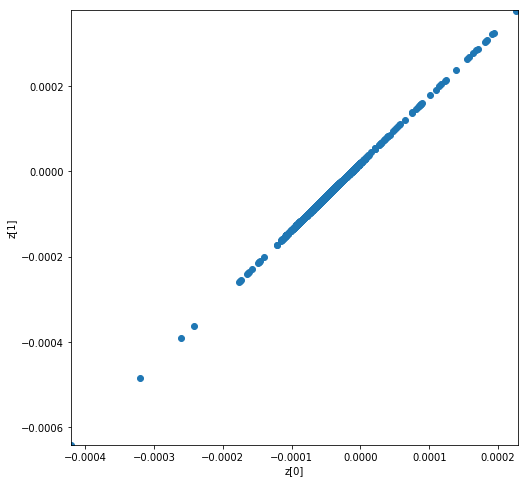

In [372]:
#plot_results(models, data, batch_size=batch_size, model_name="vae_mlp")
model_name = 'vae_mlp'
x_test, y_test = data
os.makedirs(model_name, exist_ok=True)

filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.xlim(min(z_mean[:, 0]), max(z_mean[:, 0]))
plt.ylim(min(z_mean[:, 1]), max(z_mean[:, 1]))
plt.scatter(z_mean[:, 0], z_mean[:, 1])#, c=y_test)
#plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
# plt.savefig(filename)
plt.show()

# filename = os.path.join(model_name, "digits_over_latent.png")
# # display a 30x30 2D manifold of digits
# n = 30
# digit_size = 28
# figure = np.zeros((digit_size * n, digit_size * n))
# # linearly spaced coordinates corresponding to the 2D plot
# # of digit classes in the latent space
# grid_x = np.linspace(-4, 4, n)
# grid_y = np.linspace(-4, 4, n)[::-1]

# for i, yi in enumerate(grid_y):
#     for j, xi in enumerate(grid_x):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = decoder.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit

# plt.figure(figsize=(10, 10))
# start_range = digit_size // 2
# end_range = n * digit_size + start_range + 1
# pixel_range = np.arange(start_range, end_range, digit_size)
# sample_range_x = np.round(grid_x, 1)
# sample_range_y = np.round(grid_y, 1)
# plt.xticks(pixel_range, sample_range_x)
# plt.yticks(pixel_range, sample_range_y)
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.imshow(figure, cmap='Greys_r')
# plt.savefig(filename)
# plt.show()


HACKY HACKY HACKY WE WERE IN A HURRY AT THIS POINT OK???

In [390]:
lowest_four = [(np.Inf,0), (np.Inf,0), (np.Inf,0), (np.Inf,0)]
for i in range(len(z_mean)):
    if z_mean[i][0] < lowest_four[0][0]:
        lowest_four[0] = (z_mean[i][0],i) 
    elif z_mean[i][0] < lowest_four[1][0]:
        lowest_four[1] = (z_mean[i][0],i) 
    elif z_mean[i][0] < lowest_four[2][0]:
        lowest_four[2] = (z_mean[i][0],i) 
    elif z_mean[i][0] < lowest_four[3][0]:
        lowest_four[3] = (z_mean[i][0],i) 

In [391]:
lowest_four

[(-0.00042025372, 68569),
 (-0.00024250522, 68834),
 (-0.000176806, 70525),
 (-0.00014745444, 71745)]

In [396]:
x_test[68569]

array([1.95477983e-03, 1.95512009e-03, 3.86109172e-12, 3.86109172e-12,
       9.00921402e-12, 7.43903672e-10, 1.95907619e-03, 1.95923610e-03,
       3.86109172e-12, 3.86109172e-12, 9.00921402e-12, 7.43903672e-10,
       1.95997823e-03, 1.96056593e-03, 3.86109172e-12, 3.86109172e-12,
       9.00921402e-12, 7.43903672e-10, 1.96890405e-03, 0.00000000e+00,
       3.86109172e-12, 3.86109172e-12, 9.00921402e-12, 7.43903672e-10,
       1.97184376e-03, 1.97266373e-03, 3.86109172e-12, 3.86109172e-12,
       1.02962446e-11, 7.45190703e-10, 1.98478156e-03, 1.98510626e-03,
       3.86109172e-12, 3.86109172e-12, 1.02962446e-11, 7.45190703e-10,
       1.84129155e-03, 1.84181373e-03, 3.86109172e-12, 3.86109172e-12,
       9.00921402e-12, 7.43903672e-10, 1.87044828e-03, 1.87173858e-03,
       3.86109172e-12, 3.86109172e-12, 9.00921402e-12, 7.43903672e-10,
       1.85086875e-03, 1.85115525e-03, 3.86109172e-12, 3.86109172e-12,
       9.00921402e-12, 7.43903672e-10, 1.84429546e-03, 1.84559536e-03,
      